In [119]:
#To implement the Shor's algoithm only using the optimized parameter values as given in the paper

#Import
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import numpy as np
import math
from random import randrange

N = 2077 #Any desired composite number consiting of two prime numbers to be factorized

#Choosing a random value for a

counter = 0

while True:
    a = randrange(2,N)
    counter += 1
    if np.gcd(a,N) == 1:
        break
print("The number a is: ", a, " at the counter: ", counter)


#Choosing the best parameter values for the circuit

from math import log2, ceil, pi
e = 0.1

L = ceil(log2(N))
t = ceil(2*L + 1 + (2+ 1/(2*e)))

print("L: ", L)
print("t: ", t)
print("e: ", e)

#Following code block is taken as an inspiration
#Binray representation 
def toBinary(val):
    binary = ''
    loop = val

    while loop> 0:
        temp = loop % 2
        loop = loop // 2
        binary += str(temp)

    binary = binary[::-1]
    return binary

#Integer representation
def toInteger(val: str): 

    num = 0
    val = val[::-1]

    for i in range(len(val)):
        if val[i] == '0':
            continue

        else:
            num += 2**i
    return num

#Unitary Gate opUx

def opUx(a,power,N):
    n = len(toBinary(t))
    l = len(toBinary(ceil(log2(N))))
    # qreg1 = QuantumRegister(n,"qreg1")
    # qreg2 = QuantumRegister(L,"qreg2")

    # creg = ClassicalRegister(2*L + 1, "creg")

    qc = QuantumCircuit(n)
    


    for i in range(power):
        for j in range(n-1, 0, -1):
            qc.swap(j-1, j)
        for j in range(n):
            qc.x(j)

    qc.name = f'{a}^{power} mod {N}'

    qc = qc.to_gate()
    c_qc = qc.control()

    return c_qc
            




The number a is:  1730  at the counter:  1
L:  12
t:  32
e:  0.1


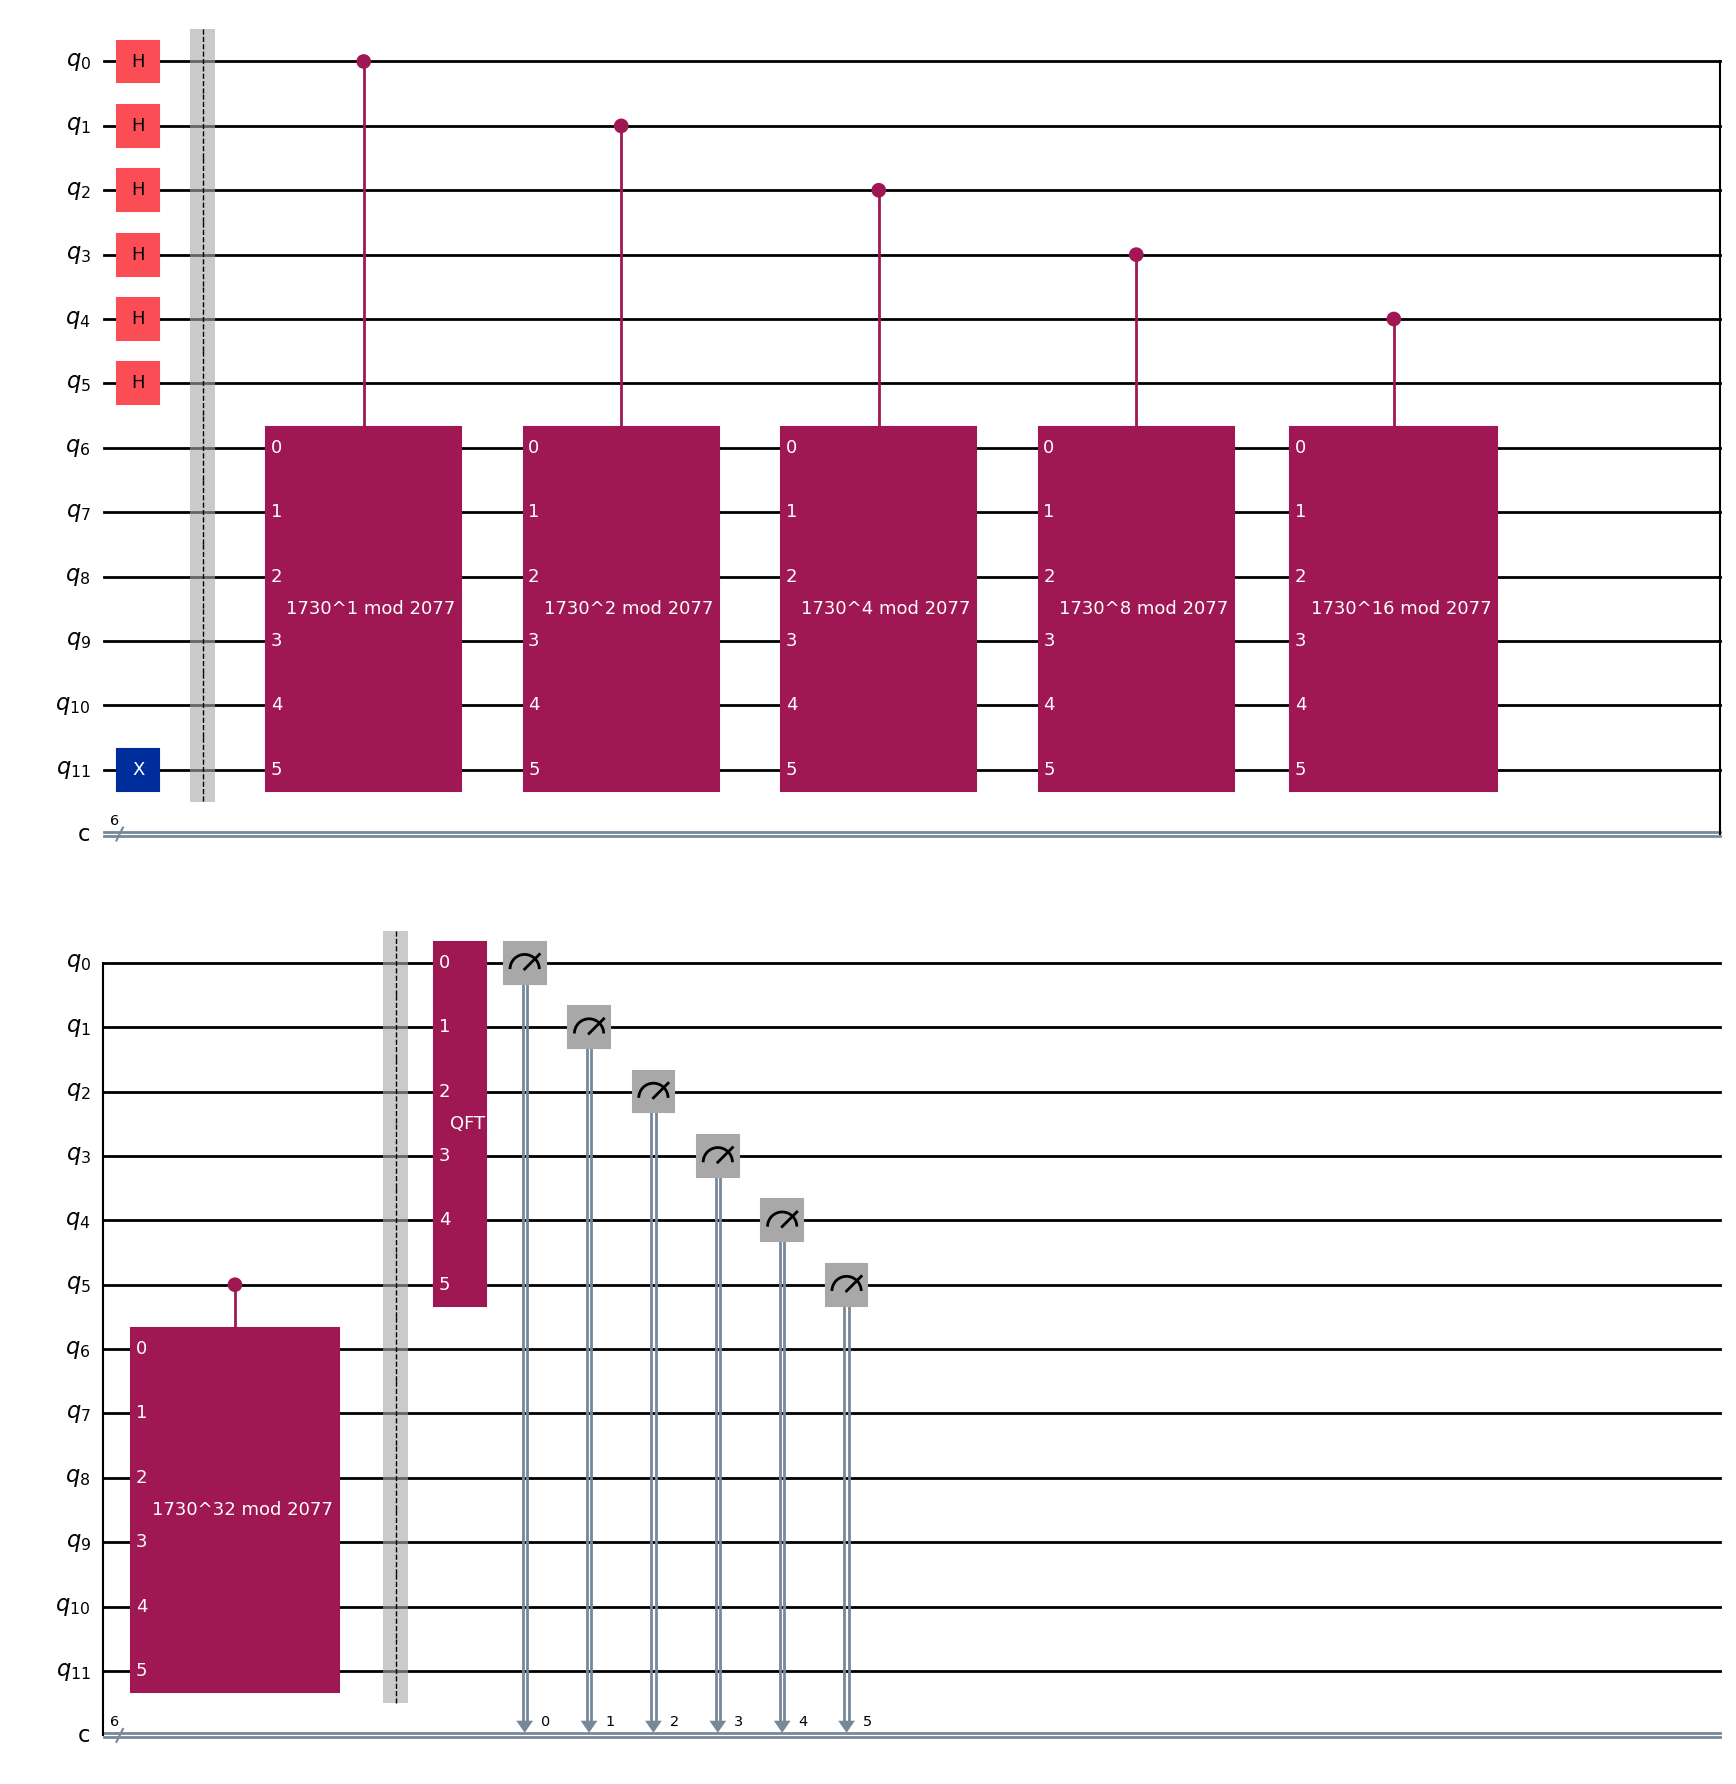

In [120]:
n = len(toBinary(t))
m = 2*n


circuit = QuantumCircuit(m,n)

for i in range(n):
    circuit.h(i)

circuit.x(m-1)
circuit.barrier()

for i in range(n):
    circuit.append(opUx(a, 2**i, N), [i]+[j+n for j in range(m-n)])

circuit.barrier()

qft = QFT(n)
qft.inverse()
circuit.append(qft, range(n))

circuit.measure(range(n), range(n))
display(circuit.draw('mpl'))


[{21: 0.1171875, 18: 0.0048828125, 34: 0.0009765625, 11: 0.1279296875, 2: 0.0009765625, 53: 0.1103515625, 43: 0.1162109375, 55: 0.0068359375, 0: 0.1591796875, 32: 0.171875, 20: 0.0078125, 3: 0.0009765625, 44: 0.0078125, 52: 0.0126953125, 38: 0.0029296875, 15: 0.0029296875, 1: 0.001953125, 42: 0.0166015625, 54: 0.0341796875, 23: 0.00390625, 45: 0.001953125, 51: 0.00390625, 33: 0.0009765625, 10: 0.01953125, 50: 0.0009765625, 46: 0.001953125, 27: 0.0009765625, 22: 0.03125, 56: 0.001953125, 60: 0.0009765625, 13: 0.001953125, 39: 0.0009765625, 9: 0.00390625, 30: 0.0009765625, 16: 0.0009765625, 25: 0.0009765625, 47: 0.0009765625, 6: 0.0009765625, 49: 0.0009765625, 8: 0.001953125, 59: 0.0009765625, 41: 0.001953125, 29: 0.0009765625, 7: 0.0009765625, 12: 0.00390625, 17: 0.0009765625, 40: 0.001953125, 19: 0.0009765625}]


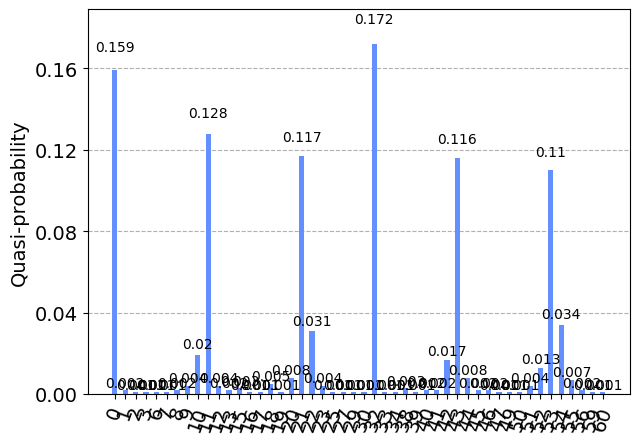

In [121]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer.primitives import Sampler

# Simulation using the sampler class.
def samplerSimulator(circuit):
    sampler = Sampler()
    results = sampler.run(circuit).result() # create a simulator to test the circuit and get the results from it.
    probabilities = results.quasi_dists # separate the probability of the values 
    return probabilities

# Secondary simulator using the BasicSimulator() class
def basicSimulator(circuit):
    backend = BasicSimulator()
    tqc = transpile(circuit, backend)
    counts = backend.run(tqc).result().get_counts()
    return counts

probabilities = samplerSimulator(circuit)
print(probabilities)

display(plot_histogram(probabilities))


In [122]:
def getResultsList(probabilities):
    results_list = []
    for key in probabilities:     # unpack the map
        for j in key:      # get all the measured vectors
            if j == 0:     # if the output is 0, we can discard it since it is not usefult as a period guesser
                continue
            else:
                results_list.append(j)
    return results_list

def printPQ(p, q):

    # The circuit implementation of Shor's algorithm cannot find a value for "p" and "q" if the value of "a"
    # from the start is a factor of the vale "N", thus we can inform the tester about it here
    if N % a == 0: 
        p = a
        q = N // a
        print("The value you chose for \"a\" is a factor of \"N\"!")
        print("N =",N)
        print("Prime Factor 1 =",p)
        print("Prime Factor 2 =",q)

    else:
        if p != 0:             # given a value p that is not 0/1, we can find the other value of q, since N = p * q => q = N / p
            q = N // p
        elif q != 0:           # given a value q that is not 0/1, we can find the other value of p, since N = p * q => p = N / q
            p = N // q

        if p == 0 and q == 0:  # if both p and q are 0, that means that we don't have propper factors, thus search for another value for "a"
            print("Try a different value for \"a\"!")
        else:
            print("N =",N)
            print("Prime Factor 1 =",p)
            print("Prime Factor 2 =",q)

In [123]:
# i. Extract the list of possible periods "r" from the results of the Quantum Simulation
r_options = getResultsList(probabilities)

print("Periodicity from the circuit =>",r_options)

# Find the values for the factors "p" and "q"
p = 0
q = 0
for i in r_options:
    if i % 2 == 0:
        x = (a**(i//2)) % N # Compute the periodicity check by applying modulus arithmetic.
        temp_p = math.gcd(x-1, N) # Find the GCD between the value of x-1 and N
        temp_q = math.gcd(x+1, N) # Find the GCD between the value of x+1 and N

        # if the values of temp_p and temp_q are 1 or N, then we need to check for other
        # values since they are not our key answers
        if temp_p != 1 and temp_p != N: 
            p = temp_p
        if temp_q != 1 and temp_q != N:
            q = temp_q 
        else:
            continue
    else:
        continue

Periodicity from the circuit => [21, 18, 34, 11, 2, 53, 43, 55, 32, 20, 3, 44, 52, 38, 15, 1, 42, 54, 23, 45, 51, 33, 10, 50, 46, 27, 22, 56, 60, 13, 39, 9, 30, 16, 25, 47, 6, 49, 8, 59, 41, 29, 7, 12, 17, 40, 19]


In [124]:
printPQ(p, q)

N = 2077
Prime Factor 1 = 31
Prime Factor 2 = 67


{'010101': 102, '001011': 130, '000000': 186, '100000': 188, '110101': 126, '101011': 99, '001010': 34, '001100': 7, '110110': 24, '010111': 12, '010110': 19, '010010': 3, '101001': 6, '001000': 5, '101100': 4, '111001': 2, '111010': 1, '101010': 14, '101000': 2, '101110': 2, '110011': 2, '010100': 13, '011011': 2, '011101': 1, '110100': 4, '110111': 6, '001111': 3, '000100': 1, '011001': 1, '001001': 2, '101111': 4, '011010': 1, '101101': 2, '010011': 2, '011000': 2, '000001': 1, '010000': 1, '110010': 3, '001101': 1, '111000': 1, '100100': 1, '001110': 1, '111100': 1, '110000': 1, '111111': 1}


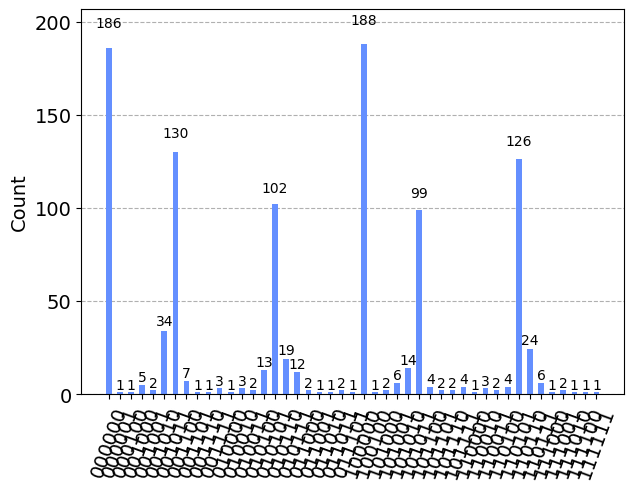

In [125]:
counts = basicSimulator(circuit)
print(counts)

keys = []
for i in counts:
    keys.append(i)

display(plot_histogram(counts))

In [126]:
r_candidates = []
for i in keys:
    if toInteger(i) == 0:
        continue
    else:
        r_candidates.append(toInteger(i))

p = 0
q = 0
for i in r_candidates:
    if i % 2 == 0:
        x = (a**(i//2)) % N
        temp_p = math.gcd(x-1, N)
        temp_q = math.gcd(x+1, N)
        
        if temp_p != 1 and temp_p != N:
            p = temp_p
        if temp_q != 1 and temp_q != N:
            q = temp_q 
        else:
            continue
    else:
        continue

printPQ(p, q)

N = 2077
Prime Factor 1 = 31
Prime Factor 2 = 67


In [127]:
#Some Circuit Properties

print(circuit.depth())
print()
print(circuit.width())
print()
print(circuit.count_ops())


9

18

OrderedDict([('h', 6), ('measure', 6), ('barrier', 2), ('x', 1), ('c1730^1 mod 2077', 1), ('c1730^2 mod 2077', 1), ('c1730^4 mod 2077', 1), ('c1730^8 mod 2077', 1), ('c1730^16 mod 2077', 1), ('c1730^32 mod 2077', 1), ('QFT', 1)])


#### It is evident that the this type of implementation using specified values for the t and L qubits or say the target qubits  


##### Now let's take it a step further and compare the two implementations based on their width so that we can know about their resource usage for each execution

In [90]:
#Let's take the numbers which we will need to factorize and compare in their terms

N = [21, 119, 209]

#Let's make list to store the depths of both the implementation
width1 = []
width2 = []

### let's first take the first implementation (no use of t, L qubit range)

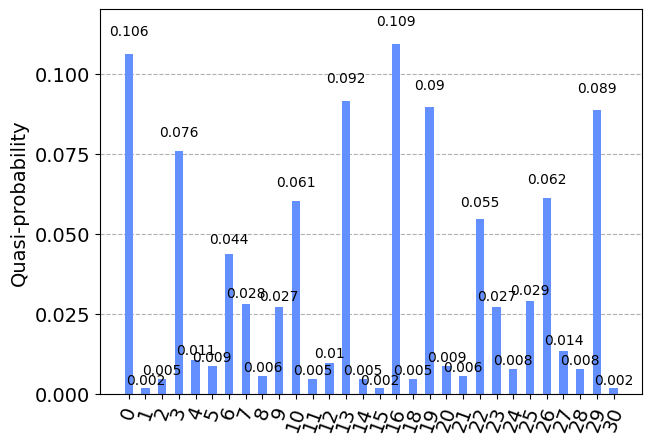

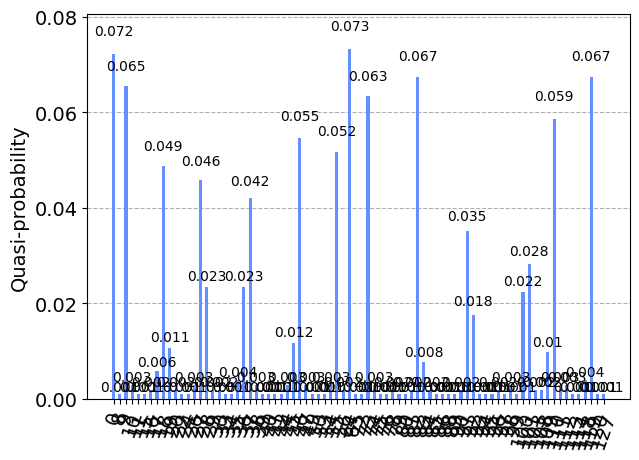

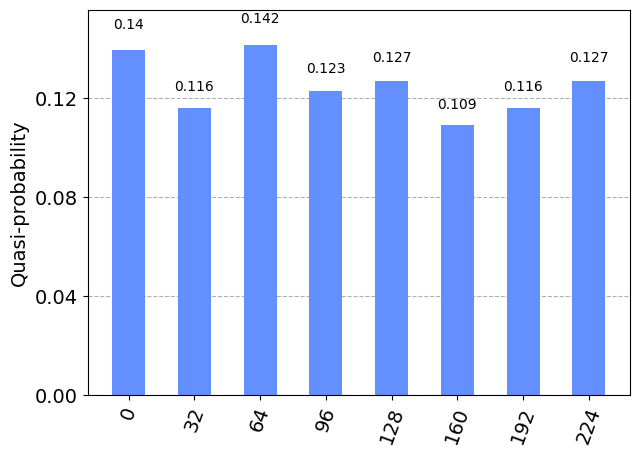

In [91]:
import random as rand
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer.primitives import Sampler
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
import math

for i in N:
    N_new = i
    counter = 0
    while True:
        a = rand.randrange(2,N_new) 
        counter += 1
        if np.gcd(a,N_new) == 1:
            break
        
        # Define the value of "a" that will be used to implement the Shor's algorithm

    def toBinary(val):
        binary = ''
        loop = val

        while loop> 0:
            temp = loop % 2
            loop = loop // 2
            binary += str(temp)

        binary = binary[::-1]
        return binary
    def toInteger(val: str): 

        num = 0
        val = val[::-1]

        for i in range(len(val)):
            if val[i] == '0':
                continue

            else:
                num += 2**i
        return num
    
    #Implementing the Unitary Gate
    def opUx(a, power, N_new):
        to_binary = toBinary(N_new) # Generate the binary representation of the test number "N"
        n = len(to_binary)      # From the binary representation, we can determine the number of bits needed to build the circuit

        circuit = QuantumCircuit(n) # Create a new circuit
        
        for i in range(power):
            for j in range(n-1, 0, -1):
                circuit.swap(j-1, j)     # Swap all the gates linearly
            for j in range(n):
                circuit.x(j)             # Apply an x gate to all the qubits
        
        circuit.name = f'{a}^{power} mod {N_new}' # Rename the circuit based on the test value and the current power
        # display(circuit.draw('mpl'))
        circuit = circuit.to_gate()
        c_circuit = circuit.control()
        return c_circuit
    
    N_binary = toBinary(N_new) # Generate the binary representation of the number so that we can generate the number of qubits needed.
    n = len(N_binary) 
    m = 2 * n

    circuit = QuantumCircuit(m, n)

    # apply the hadamard gate to the input value
    for i in range(n):
        circuit.h(i)

    # Helper x gate
    circuit.x(m-1)
    circuit.barrier()

    # Modify the circuit so that we can install the Controll-ROT gate.
    # opUx implements an instance of the UROT gate per each power basis, 
    # and the following loop tells the c_amodN gate which qubits it can 
    # apply to.

    for i in range(n):
        circuit.append(opUx(a, 2**i, N_new), [i]+[j+n for j in range(m-n)])

    circuit.barrier()

    qft = QFT(n)
    qft.inverse()
    circuit.append(qft, range(n))

    circuit.measure(range(n), range(n))

    def samplerSimulator(circuit):
        sampler = Sampler()
        results = sampler.run(circuit).result() # create a simulator to test the circuit and get the results from it.
        probabilities = results.quasi_dists # separate the probability of the values 
        return probabilities

    # Secondary simulator using the BasicSimulator() class
    def basicSimulator(circuit):
        backend = BasicSimulator()
        tqc = transpile(circuit, backend)
        counts = backend.run(tqc).result().get_counts()
        return counts
    
    probabilities = samplerSimulator(circuit)

    display(plot_histogram(probabilities))

    def getResultsList(probabilities):
        results_list = []
        for key in probabilities:     # unpack the map
            for j in key:      # get all the measured vectors
                if j == 0:     # if the output is 0, we can discard it since it is not usefult as a period guesser
                    continue
                else:
                    results_list.append(j)
        return results_list
    

    def printPQ(p, q):

        # The circuit implementation of Shor's algorithm cannot find a value for "p" and "q" if the value of "a"
        # from the start is a factor of the vale "N", thus we can inform the tester about it here
        if N_new % a == 0: 
            p = a
            q = N_new // a

        else:
            if p != 0:             # given a value p that is not 0/1, we can find the other value of q, since N = p * q => q = N / p
                q = N_new // p
            elif q != 0:           # given a value q that is not 0/1, we can find the other value of p, since N = p * q => p = N / q
                p = N_new // q

    
    # i. Extract the list of possible periods "r" from the results of the Quantum Simulation
    r_options = getResultsList(probabilities)

    # Find the values for the factors "p" and "q"
    p = 0
    q = 0
    for i in r_options:
        if i % 2 == 0:
            x = (a**(i//2)) % N_new# Compute the periodicity check by applying modulus arithmetic.
            temp_p = math.gcd(x-1, N_new) # Find the GCD between the value of x-1 and N
            temp_q = math.gcd(x+1, N_new) # Find the GCD between the value of x+1 and N

            # if the values of temp_p and temp_q are 1 or N, then we need to check for other
            # values since they are not our key answers
            if temp_p != 1 and temp_p != N_new: 
                p = temp_p
            if temp_q != 1 and temp_q != N_new:
                q = temp_q 
            else:
                continue
        else:
            continue

    counts = basicSimulator(circuit)
    keys = []
    for i in counts:
        keys.append(i)


    r_candidates = []
    for i in keys:
        if toInteger(i) == 0:
            continue
        else:
            r_candidates.append(toInteger(i))

    p = 0
    q = 0
    for i in r_candidates:
        if i % 2 == 0:
            x = (a**(i//2)) % N_new
            temp_p = math.gcd(x-1, N_new)
            temp_q = math.gcd(x+1, N_new)
            
            if temp_p != 1 and temp_p != N_new:
                p = temp_p
            if temp_q != 1 and temp_q != N_new:
                q = temp_q 
            else:
                continue
        else:
            continue

    width1.append(circuit.width())
    
    


In [92]:
print(width1)

[15, 21, 24]


#### let's do the second implementation using the preffered values of t and L

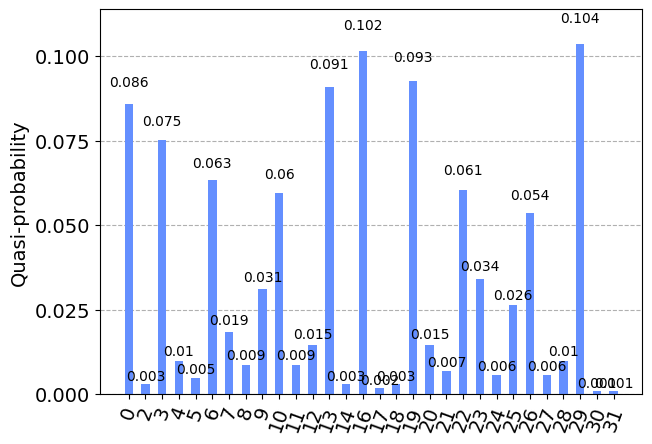

N = 21
Prime Factor 1 = 3
Prime Factor 2 = 7


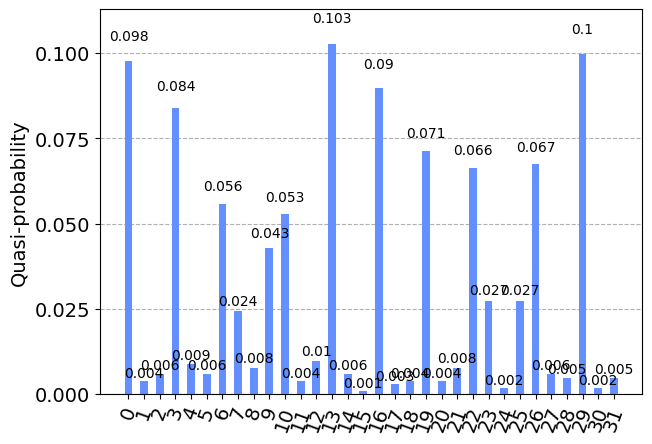

N = 119
Prime Factor 1 = 7
Prime Factor 2 = 17


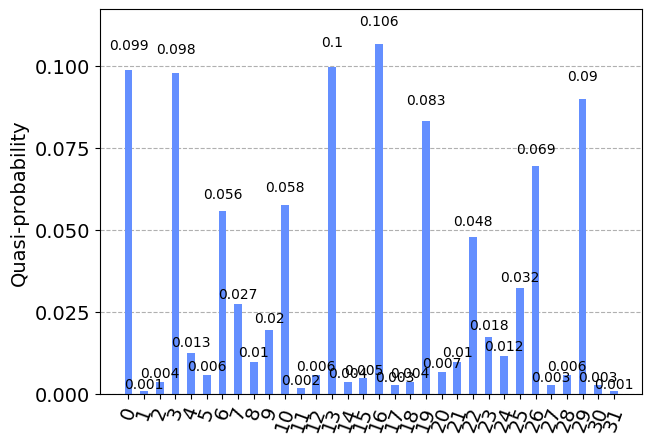

N = 209
Prime Factor 1 = 19
Prime Factor 2 = 11


In [96]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import numpy as np
import math
from random import randrange

for i in [21, 119, 209]:
    
    N_new = i

    counter = 0

    while True:
        a = randrange(2,N_new)
        counter += 1
        if np.gcd(a,N_new) == 1:
            break


    #Choosing the best parameter values for the circuit

    from math import log2, ceil, pi
    e = 0.1

    L = ceil(log2(N_new))
    t = ceil(2*L + 1 + (2+ 1/(2*e)))

    #Following code block is taken as an inspiration
    #Binray representation 
    def toBinary(val):
        binary = ''
        loop = val

        while loop> 0:
            temp = loop % 2
            loop = loop // 2
            binary += str(temp)

        binary = binary[::-1]
        return binary

    #Integer representation
    def toInteger(val: str): 

        num = 0
        val = val[::-1]

        for i in range(len(val)):
            if val[i] == '0':
                continue

            else:
                num += 2**i
        return num

    #Unitary Gate opUx

    def opUx(a,power,N_new):
        n = len(toBinary(t))
        l = len(toBinary(ceil(log2(N_new))))
        # qreg1 = QuantumRegister(n,"qreg1")
        # qreg2 = QuantumRegister(L,"qreg2")

        # creg = ClassicalRegister(2*L + 1, "creg")

        qc = QuantumCircuit(n)
        


        for i in range(power):
            for j in range(n-1, 0, -1):
                qc.swap(j-1, j)
            for j in range(n):
                qc.x(j)

        qc.name = f'{a}^{power} mod {N_new}'

        qc = qc.to_gate()
        c_qc = qc.control()

        return c_qc
    
    n = len(toBinary(t))
    m = 2*n


    circuit = QuantumCircuit(m,n)

    for i in range(n):
        circuit.h(i)

    circuit.x(m-1)
    circuit.barrier()

    for i in range(n):
        circuit.append(opUx(a, 2**i, N_new), [i]+[j+n for j in range(m-n)])

    circuit.barrier()

    qft = QFT(n)
    qft.inverse()
    circuit.append(qft, range(n))

    circuit.measure(range(n), range(n))

    from qiskit.providers.basic_provider import BasicSimulator
    from qiskit_aer.primitives import Sampler

    # Simulation using the sampler class.
    def samplerSimulator(circuit):
        sampler = Sampler()
        results = sampler.run(circuit).result() # create a simulator to test the circuit and get the results from it.
        probabilities = results.quasi_dists # separate the probability of the values 
        return probabilities

    # Secondary simulator using the BasicSimulator() class
    def basicSimulator(circuit):
        backend = BasicSimulator()
        tqc = transpile(circuit, backend)
        counts = backend.run(tqc).result().get_counts()
        return counts

    probabilities = samplerSimulator(circuit)
    display(plot_histogram(probabilities))




    def getResultsList(probabilities):
        results_list = []
        for key in probabilities:     # unpack the map
            for j in key:      # get all the measured vectors
                if j == 0:     # if the output is 0, we can discard it since it is not usefult as a period guesser
                    continue
                else:
                    results_list.append(j)
        return results_list

    # def printPQ(p, q):

    #     # The circuit implementation of Shor's algorithm cannot find a value for "p" and "q" if the value of "a"
    #     # from the start is a factor of the vale "N", thus we can inform the tester about it here
    #     if N_new % a == 0: 
    #         p = a
    #         q = N_new // a

    #     else:
    #         if p != 0:             # given a value p that is not 0/1, we can find the other value of q, since N = p * q => q = N / p
    #             q = N_new // p
    #         elif q != 0:           # given a value q that is not 0/1, we can find the other value of p, since N = p * q => p = N / q
    #             p = N_new // q

    def printPQ(p, q):

        # The circuit implementation of Shor's algorithm cannot find a value for "p" and "q" if the value of "a"
        # from the start is a factor of the vale "N", thus we can inform the tester about it here
        if N_new % a == 0: 
            p = a
            q = N_new // a
            print("The value you chose for \"a\" is a factor of \"N\"!")
            print("N =",N_new)
            print("Prime Factor 1 =",p)
            print("Prime Factor 2 =",q)

        else:
            if p != 0:             # given a value p that is not 0/1, we can find the other value of q, since N = p * q => q = N / p
                q = N_new // p
            elif q != 0:           # given a value q that is not 0/1, we can find the other value of p, since N = p * q => p = N / q
                p = N_new // q

            if p == 0 and q == 0:  # if both p and q are 0, that means that we don't have propper factors, thus search for another value for "a"
                print("Try a different value for \"a\"!")
            else:
                print("N =",N_new)
                print("Prime Factor 1 =",p)
                print("Prime Factor 2 =",q)

        # i. Extract the list of possible periods "r" from the results of the Quantum Simulation
    r_options = getResultsList(probabilities)

    # print("Periodicity from the circuit =>",r_options)

    # Find the values for the factors "p" and "q"
    p = 0
    q = 0
    for i in r_options:
        if i % 2 == 0:
            x = (a**(i//2)) % N_new # Compute the periodicity check by applying modulus arithmetic.
            temp_p = math.gcd(x-1, N_new) # Find the GCD between the value of x-1 and N
            temp_q = math.gcd(x+1, N_new) # Find the GCD between the value of x+1 and N

            # if the values of temp_p and temp_q are 1 or N, then we need to check for other
            # values since they are not our key answers
            if temp_p != 1 and temp_p != N_new: 
                p = temp_p
            if temp_q != 1 and temp_q != N_new:
                q = temp_q 
            else:
                continue
        else:
            continue

    counts = basicSimulator(circuit)
    keys = []
    for i in counts:
        keys.append(i)


    r_candidates = []
    for i in keys:
        if toInteger(i) == 0:
            continue
        else:
            r_candidates.append(toInteger(i))

    p = 0
    q = 0
    for i in r_candidates:
        if i % 2 == 0:
            x = (a**(i//2)) % N_new
            temp_p = math.gcd(x-1, N_new)
            temp_q = math.gcd(x+1, N_new)
            
            if temp_p != 1 and temp_p != N_new:
                p = temp_p
            if temp_q != 1 and temp_q != N_new:
                q = temp_q 
            else:
                continue
        else:
            continue
        
    
    printPQ(p, q)

    width2.append(circuit.width())    

    

In [97]:
print(width2)

[15, 15, 15, 15, 15, 15, 15, 15, 15]


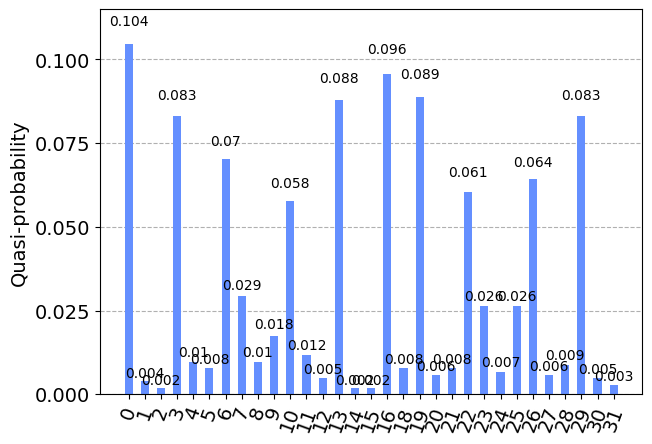

N = 21
Prime Factor 1 = 7
Prime Factor 2 = 3


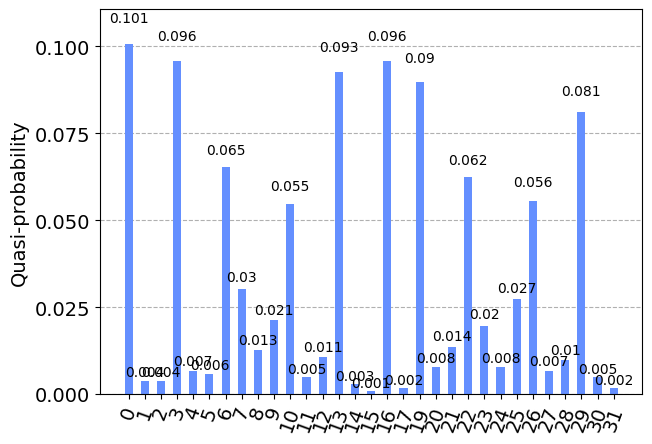

N = 119
Prime Factor 1 = 17
Prime Factor 2 = 7


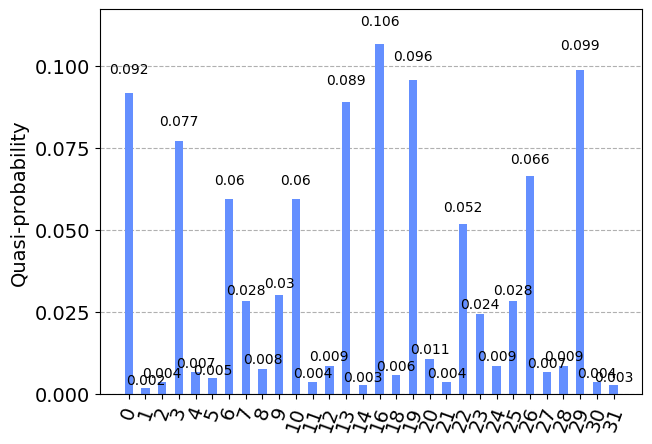

N = 209
Prime Factor 1 = 19
Prime Factor 2 = 11
Circuit widths for different N values: [15, 15, 15]


In [98]:
N = [21, 119, 209]
width2 = []

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import numpy as np
import math
from random import randrange

for i in N:
    
    N_new = i
    counter = 0

    while True:
        a = randrange(2, N_new)
        counter += 1
        if np.gcd(a, N_new) == 1:
            break

    # Choosing the best parameter values for the circuit
    from math import log2, ceil, pi
    e = 0.1

    L = ceil(log2(N_new))
    t = ceil(2*L + 1 + (2 + 1/(2*e)))

    def toBinary(val):
        binary = ''
        loop = val

        while loop > 0:
            temp = loop % 2
            loop = loop // 2
            binary += str(temp)

        binary = binary[::-1]
        return binary

    def toInteger(val: str):
        num = 0
        val = val[::-1]

        for i in range(len(val)):
            if val[i] == '0':
                continue
            else:
                num += 2**i
        return num

    def opUx(a, power, N_new):
        n = len(toBinary(t))
        qc = QuantumCircuit(n)

        for i in range(power):
            for j in range(n-1, 0, -1):
                qc.swap(j-1, j)
            for j in range(n):
                qc.x(j)

        qc.name = f'{a}^{power} mod {N_new}'
        qc = qc.to_gate()
        c_qc = qc.control()

        return c_qc
    
    n = len(toBinary(t))
    m = 2*n

    # Create a new quantum circuit for each iteration to avoid width issues
    circuit = QuantumCircuit(m, n)

    for i in range(n):
        circuit.h(i)

    circuit.x(m-1)
    circuit.barrier()

    for i in range(n):
        circuit.append(opUx(a, 2**i, N_new), [i] + [j+n for j in range(m-n)])

    circuit.barrier()

    qft = QFT(n)
    qft.inverse()
    circuit.append(qft, range(n))

    circuit.measure(range(n), range(n))

    from qiskit.providers.basic_provider import BasicSimulator
    from qiskit_aer.primitives import Sampler

    def samplerSimulator(circuit):
        sampler = Sampler()
        results = sampler.run(circuit).result()
        probabilities = results.quasi_dists
        return probabilities

    def basicSimulator(circuit):
        backend = BasicSimulator()
        tqc = transpile(circuit, backend)
        counts = backend.run(tqc).result().get_counts()
        return counts

    probabilities = samplerSimulator(circuit)
    display(plot_histogram(probabilities))

    def getResultsList(probabilities):
        results_list = []
        for key in probabilities:
            for j in key:
                if j == 0:
                    continue
                else:
                    results_list.append(j)
        return results_list

    def printPQ(p, q):
        if N_new % a == 0:
            p = a
            q = N_new // a
            print("The value you chose for \"a\" is a factor of \"N\"!")
            print("N =", N_new)
            print("Prime Factor 1 =", p)
            print("Prime Factor 2 =", q)
        else:
            if p != 0:
                q = N_new // p
            elif q != 0:
                p = N_new // q

            if p == 0 and q == 0:
                print("Try a different value for \"a\"!")
            else:
                print("N =", N_new)
                print("Prime Factor 1 =", p)
                print("Prime Factor 2 =", q)

    r_options = getResultsList(probabilities)

    p = 0
    q = 0
    for i in r_options:
        if i % 2 == 0:
            x = (a**(i//2)) % N_new
            temp_p = math.gcd(x-1, N_new)
            temp_q = math.gcd(x+1, N_new)

            if temp_p != 1 and temp_p != N_new:
                p = temp_p
            if temp_q != 1 and temp_q != N_new:
                q = temp_q 
            else:
                continue
        else:
            continue

    counts = basicSimulator(circuit)
    keys = []
    for i in counts:
        keys.append(i)

    r_candidates = []
    for i in keys:
        if toInteger(i) == 0:
            continue
        else:
            r_candidates.append(toInteger(i))

    p = 0
    q = 0
    for i in r_candidates:
        if i % 2 == 0:
            x = (a**(i//2)) % N_new
            temp_p = math.gcd(x-1, N_new)
            temp_q = math.gcd(x+1, N_new)

            if temp_p != 1 and temp_p != N_new:
                p = temp_p
            if temp_q != 1 and temp_q != N_new:
                q = temp_q 
            else:
                continue
        else:
            continue
    
    printPQ(p, q)

    width2.append(circuit.width())

print("Circuit widths for different N values:", width2)


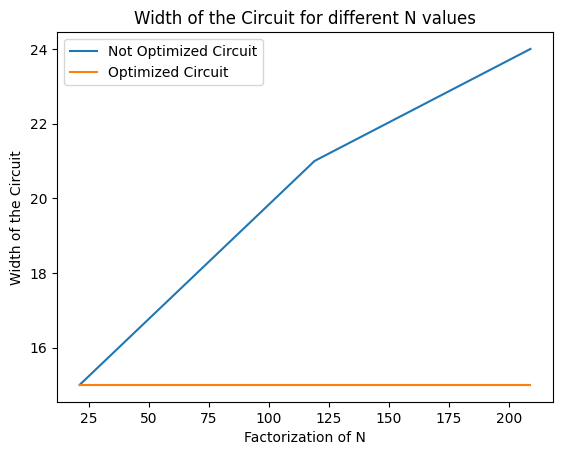

In [100]:
import matplotlib.pyplot as plt

plt.plot(N, width1, label='Not Optimized Circuit')
plt.plot(N, width2, label='Optimized Circuit')
plt.xlabel("Factorization of N")
plt.ylabel("Width of the Circuit")
plt.title("Width of the Circuit for different N values")
plt.legend()
plt.show()